# Iris Species Classification with PyTorch
For details, see also
- https://github.com/pratibhashinde/Project-Iris-PyTorch/blob/master/iris_pytorch.ipynb (primary code source),
- https://pytorch.org/tutorials/beginner/saving_loading_models.html (on saving and loading pytorch models), and
- ddd (docker tutorial to which this notebook belongs).

Start by importing required libraries and the iris dataset from the *iris.csv* file. Of course, the iris dataset could also be imported via `from sklearn.datasets import load_iris` but within the docker tutorial (see third link above), we also want to demonstrate the usage of **volumes** that make files on the host (like *iris.csv*) available to a program inside a running docker container (like this jupyter notebook).

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
from sklearn.metrics import accuracy_score
np.random.seed(7)
# load and display data
df = pd.read_csv('iris.csv')
print(df)
# converting name (=species) labels to 0, 1, 2
df.loc[df.Name=='Iris-setosa', 'Name'] = 0
df.loc[df.Name=='Iris-versicolor', 'Name'] = 1
df.loc[df.Name=='Iris-virginica', 'Name'] = 2
df

     SepalLength  SepalWidth  PetalLength  PetalWidth            Name
0            5.1         3.5          1.4         0.2     Iris-setosa
1            4.9         3.0          1.4         0.2     Iris-setosa
2            4.7         3.2          1.3         0.2     Iris-setosa
3            4.6         3.1          1.5         0.2     Iris-setosa
4            5.0         3.6          1.4         0.2     Iris-setosa
..           ...         ...          ...         ...             ...
145          6.7         3.0          5.2         2.3  Iris-virginica
146          6.3         2.5          5.0         1.9  Iris-virginica
147          6.5         3.0          5.2         2.0  Iris-virginica
148          6.2         3.4          5.4         2.3  Iris-virginica
149          5.9         3.0          5.1         1.8  Iris-virginica

[150 rows x 5 columns]


,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


We have imported the data and converted the iris species *iris-setosa*, *iris-versicolor*, and *iris-virginica* to integer values 0, 1, and 2, respectively. Now, we split the dataset into features X and labels Y, shuffle the instances, and divide it into subsets for training, validation, and testing.

In [2]:
split_ratio = 0.8
X = df[df.columns[0:4]].values
Y = df[df.columns[4]].values.astype(int)
shuffle_indices = np.random.permutation(len(Y))
print(shuffle_indices[:10])
X , Y = X[shuffle_indices], Y[shuffle_indices]
print(len(Y))
split_1 = int(np.round(split_ratio * len(Y)))
split_2 = int(np.round(split_ratio * split_1))
X, X_test = X[:split_1], X[split_1:]
Y, Y_test = Y[:split_1], Y[split_1:]
print(len(X), len(X_test))
print(len(Y), len(Y_test))
print(split_1)
X, X_valid = X[:split_2], X[split_2:]
Y, Y_valid = Y[:split_2], Y[split_2:]
print(len(X), len(X_valid))
print(len(Y), len(Y_valid))
X[:10], Y[:10]

[149  84  40  66 106  41  52  94  11  51]
150
120 30
120 30
120
96 24
96 24


(array([[5.9, 3. , 5.1, 1.8],
        [5.4, 3. , 4.5, 1.5],
        [5. , 3.5, 1.3, 0.3],
        [5.6, 3. , 4.5, 1.5],
        [4.9, 2.5, 4.5, 1.7],
        [4.5, 2.3, 1.3, 0.3],
        [6.9, 3.1, 4.9, 1.5],
        [5.6, 2.7, 4.2, 1.3],
        [4.8, 3.4, 1.6, 0.2],
        [6.4, 3.2, 4.5, 1.5]]),
 array([2, 1, 0, 1, 2, 0, 1, 1, 0, 1]))

Since the iris dataset does not have many instances (namely 150) to start with, we need to make sure that classes are similarly represented in all subsets (training, validation, and testing).

In [3]:
def checkClasses(y):
    counts = [0, 0, 0]
    for i in range(len(y)):
        counts[y[i]] += 1
    return counts
checkClasses(Y), checkClasses(Y_valid), checkClasses(Y_test)

([32, 31, 33], [9, 7, 8], [9, 12, 9])

We are pretty much done with preparing the dataset and now turn to the neural net. First of all, we convert the input data into tensor format. Then, we define a class for a fully connected neural net and instatiate a net with two hidden layers where each of them has 6 neurons. As demanded by the three different classes, the output layer has three neurons that feed into a softmax activation function. We also define a filepath for saving the model.

In [4]:
X, Y = torch.Tensor(X).float(), torch.Tensor(Y)
X_valid, Y_valid = torch.Tensor(X_valid).float(), torch.Tensor(Y_valid)
X_test, Y_test = torch.Tensor(X_test).float(), torch.Tensor(Y_test)
# define model class
class net(nn.Module):
    def __init__(self, hidden_1, hidden_2):
        super(net, self).__init__()
        self.f1 = nn.Linear(4, hidden_1)
        self.a1 = nn.ReLU()
        self.f2 = nn.Linear(hidden_1, hidden_2)
        self.f3 = nn.Linear(hidden_2, 3)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.f1(x)
        x = self.a1(x)
        x = self.f2(x)
        x = self.f3(x)
        x = self.softmax(x)
        return x
# build model instance and define the path for the saved model
model = net(6, 6)
model_path = './iris_model.pth'

If there exists a saved model file from a previous training run, we can choose to load it and skip training. If such file does not exist or we choose not to load it the model will be trained and a model file will be created.

The main point here is not so much the training but the **creation of a file** (namely the file of the trained and saved model) that persists in the docker volume **beyond the lifetime of the docker container**. And it goes both ways: after stopping the container and starting a new one from the same image (while also mounting the same volume), the saved model file will still be available from inside the new docker container.

Training the model ...
Epoch: 0	Loss: 1.1038	Accuracy on validation set: 0.2917
Accuracy on validation set has just improved!
The model has been saved under ./iris_model.pth.
Epoch: 1	Loss: 1.1034	Accuracy on validation set: 0.2917
Epoch: 2	Loss: 1.1029	Accuracy on validation set: 0.2917
Epoch: 3	Loss: 1.1024	Accuracy on validation set: 0.2917
Epoch: 4	Loss: 1.1019	Accuracy on validation set: 0.2917
Epoch: 5	Loss: 1.1014	Accuracy on validation set: 0.2917
Epoch: 6	Loss: 1.1010	Accuracy on validation set: 0.2917
Epoch: 7	Loss: 1.1005	Accuracy on validation set: 0.2917
Epoch: 8	Loss: 1.1000	Accuracy on validation set: 0.2917
Epoch: 9	Loss: 1.0995	Accuracy on validation set: 0.2917
Epoch: 10	Loss: 1.0989	Accuracy on validation set: 0.2917
Epoch: 11	Loss: 1.0984	Accuracy on validation set: 0.2917
Epoch: 12	Loss: 1.0979	Accuracy on validation set: 0.2917
Epoch: 13	Loss: 1.0974	Accuracy on validation set: 0.2917
Epoch: 14	Loss: 1.0969	Accuracy on validation set: 0.2917
Epoch: 15	Loss: 1.0963

Epoch: 140	Loss: 1.0543	Accuracy on validation set: 0.3333
Epoch: 141	Loss: 1.0542	Accuracy on validation set: 0.3333
Epoch: 142	Loss: 1.0540	Accuracy on validation set: 0.3333
Epoch: 143	Loss: 1.0539	Accuracy on validation set: 0.3333
Epoch: 144	Loss: 1.0538	Accuracy on validation set: 0.3333
Epoch: 145	Loss: 1.0537	Accuracy on validation set: 0.3333
Epoch: 146	Loss: 1.0536	Accuracy on validation set: 0.3333
Epoch: 147	Loss: 1.0535	Accuracy on validation set: 0.3333
Epoch: 148	Loss: 1.0534	Accuracy on validation set: 0.3333
Epoch: 149	Loss: 1.0533	Accuracy on validation set: 0.3333
Epoch: 150	Loss: 1.0532	Accuracy on validation set: 0.3333
Epoch: 151	Loss: 1.0531	Accuracy on validation set: 0.3333
Epoch: 152	Loss: 1.0530	Accuracy on validation set: 0.3333
Epoch: 153	Loss: 1.0529	Accuracy on validation set: 0.3333
Epoch: 154	Loss: 1.0528	Accuracy on validation set: 0.3333
Epoch: 155	Loss: 1.0527	Accuracy on validation set: 0.3333
Epoch: 156	Loss: 1.0526	Accuracy on validation set: 0.33

Epoch: 303	Loss: 1.0388	Accuracy on validation set: 0.3333
Epoch: 304	Loss: 1.0387	Accuracy on validation set: 0.3333
Epoch: 305	Loss: 1.0386	Accuracy on validation set: 0.3333
Epoch: 306	Loss: 1.0385	Accuracy on validation set: 0.3333
Epoch: 307	Loss: 1.0384	Accuracy on validation set: 0.3333
Epoch: 308	Loss: 1.0383	Accuracy on validation set: 0.3333
Epoch: 309	Loss: 1.0382	Accuracy on validation set: 0.3333
Epoch: 310	Loss: 1.0381	Accuracy on validation set: 0.3333
Epoch: 311	Loss: 1.0380	Accuracy on validation set: 0.3333
Epoch: 312	Loss: 1.0379	Accuracy on validation set: 0.3333
Epoch: 313	Loss: 1.0377	Accuracy on validation set: 0.3333
Epoch: 314	Loss: 1.0376	Accuracy on validation set: 0.3333
Epoch: 315	Loss: 1.0375	Accuracy on validation set: 0.3333
Epoch: 316	Loss: 1.0374	Accuracy on validation set: 0.3333
Epoch: 317	Loss: 1.0373	Accuracy on validation set: 0.3333
Epoch: 318	Loss: 1.0372	Accuracy on validation set: 0.3333
Epoch: 319	Loss: 1.0371	Accuracy on validation set: 0.33

Epoch: 447	Loss: 1.0206	Accuracy on validation set: 0.4583
Epoch: 448	Loss: 1.0204	Accuracy on validation set: 0.4583
Epoch: 449	Loss: 1.0203	Accuracy on validation set: 0.4583
Epoch: 450	Loss: 1.0201	Accuracy on validation set: 0.4583
Epoch: 451	Loss: 1.0200	Accuracy on validation set: 0.4583
Epoch: 452	Loss: 1.0198	Accuracy on validation set: 0.4583
Epoch: 453	Loss: 1.0197	Accuracy on validation set: 0.4583
Epoch: 454	Loss: 1.0195	Accuracy on validation set: 0.4583
Epoch: 455	Loss: 1.0194	Accuracy on validation set: 0.4583
Epoch: 456	Loss: 1.0192	Accuracy on validation set: 0.4583
Epoch: 457	Loss: 1.0191	Accuracy on validation set: 0.4583
Epoch: 458	Loss: 1.0189	Accuracy on validation set: 0.4583
Epoch: 459	Loss: 1.0188	Accuracy on validation set: 0.4583
Epoch: 460	Loss: 1.0186	Accuracy on validation set: 0.5000
Epoch: 461	Loss: 1.0184	Accuracy on validation set: 0.5000
Epoch: 462	Loss: 1.0183	Accuracy on validation set: 0.5000
Epoch: 463	Loss: 1.0181	Accuracy on validation set: 0.50

Epoch: 592	Loss: 0.9957	Accuracy on validation set: 0.7083
Epoch: 593	Loss: 0.9955	Accuracy on validation set: 0.7083
Epoch: 594	Loss: 0.9953	Accuracy on validation set: 0.7083
Epoch: 595	Loss: 0.9951	Accuracy on validation set: 0.7083
Epoch: 596	Loss: 0.9949	Accuracy on validation set: 0.7083
Epoch: 597	Loss: 0.9947	Accuracy on validation set: 0.7083
Epoch: 598	Loss: 0.9945	Accuracy on validation set: 0.7083
Epoch: 599	Loss: 0.9943	Accuracy on validation set: 0.7083
Epoch: 600	Loss: 0.9941	Accuracy on validation set: 0.7083
Epoch: 601	Loss: 0.9939	Accuracy on validation set: 0.7083
Epoch: 602	Loss: 0.9937	Accuracy on validation set: 0.7083
Epoch: 603	Loss: 0.9935	Accuracy on validation set: 0.7083
Epoch: 604	Loss: 0.9933	Accuracy on validation set: 0.7083
Epoch: 605	Loss: 0.9931	Accuracy on validation set: 0.7083
Epoch: 606	Loss: 0.9928	Accuracy on validation set: 0.7083
Epoch: 607	Loss: 0.9926	Accuracy on validation set: 0.7083
Epoch: 608	Loss: 0.9924	Accuracy on validation set: 0.70

Epoch: 747	Loss: 0.9554	Accuracy on validation set: 0.7083
Epoch: 748	Loss: 0.9550	Accuracy on validation set: 0.7083
Epoch: 749	Loss: 0.9547	Accuracy on validation set: 0.7083
Epoch: 750	Loss: 0.9544	Accuracy on validation set: 0.7083
Epoch: 751	Loss: 0.9541	Accuracy on validation set: 0.7083
Epoch: 752	Loss: 0.9538	Accuracy on validation set: 0.7083
Epoch: 753	Loss: 0.9535	Accuracy on validation set: 0.7083
Epoch: 754	Loss: 0.9532	Accuracy on validation set: 0.7083
Epoch: 755	Loss: 0.9529	Accuracy on validation set: 0.7083
Epoch: 756	Loss: 0.9526	Accuracy on validation set: 0.7083
Epoch: 757	Loss: 0.9523	Accuracy on validation set: 0.7083
Epoch: 758	Loss: 0.9520	Accuracy on validation set: 0.7083
Epoch: 759	Loss: 0.9517	Accuracy on validation set: 0.7083
Epoch: 760	Loss: 0.9514	Accuracy on validation set: 0.7083
Epoch: 761	Loss: 0.9510	Accuracy on validation set: 0.7083
Epoch: 762	Loss: 0.9507	Accuracy on validation set: 0.7083
Epoch: 763	Loss: 0.9504	Accuracy on validation set: 0.70

Epoch: 901	Loss: 0.9145	Accuracy on validation set: 0.7083
Epoch: 902	Loss: 0.9142	Accuracy on validation set: 0.7083
Epoch: 903	Loss: 0.9140	Accuracy on validation set: 0.7083
Epoch: 904	Loss: 0.9137	Accuracy on validation set: 0.7083
Epoch: 905	Loss: 0.9135	Accuracy on validation set: 0.7083
Epoch: 906	Loss: 0.9132	Accuracy on validation set: 0.7083
Epoch: 907	Loss: 0.9130	Accuracy on validation set: 0.7083
Epoch: 908	Loss: 0.9127	Accuracy on validation set: 0.7083
Epoch: 909	Loss: 0.9125	Accuracy on validation set: 0.7083
Epoch: 910	Loss: 0.9123	Accuracy on validation set: 0.7083
Epoch: 911	Loss: 0.9120	Accuracy on validation set: 0.7083
Epoch: 912	Loss: 0.9118	Accuracy on validation set: 0.7083
Epoch: 913	Loss: 0.9115	Accuracy on validation set: 0.7083
Epoch: 914	Loss: 0.9113	Accuracy on validation set: 0.7083
Epoch: 915	Loss: 0.9110	Accuracy on validation set: 0.7083
Epoch: 916	Loss: 0.9108	Accuracy on validation set: 0.7083
Epoch: 917	Loss: 0.9105	Accuracy on validation set: 0.70

Epoch: 1070	Loss: 0.8766	Accuracy on validation set: 0.7083
Epoch: 1071	Loss: 0.8764	Accuracy on validation set: 0.7083
Epoch: 1072	Loss: 0.8762	Accuracy on validation set: 0.7083
Epoch: 1073	Loss: 0.8761	Accuracy on validation set: 0.7083
Epoch: 1074	Loss: 0.8759	Accuracy on validation set: 0.7083
Epoch: 1075	Loss: 0.8757	Accuracy on validation set: 0.7083
Epoch: 1076	Loss: 0.8755	Accuracy on validation set: 0.7083
Epoch: 1077	Loss: 0.8753	Accuracy on validation set: 0.7083
Epoch: 1078	Loss: 0.8752	Accuracy on validation set: 0.7083
Epoch: 1079	Loss: 0.8750	Accuracy on validation set: 0.7083
Epoch: 1080	Loss: 0.8748	Accuracy on validation set: 0.7083
Epoch: 1081	Loss: 0.8746	Accuracy on validation set: 0.7083
Epoch: 1082	Loss: 0.8744	Accuracy on validation set: 0.7083
Epoch: 1083	Loss: 0.8743	Accuracy on validation set: 0.7083
Epoch: 1084	Loss: 0.8741	Accuracy on validation set: 0.7083
Epoch: 1085	Loss: 0.8739	Accuracy on validation set: 0.7083
Epoch: 1086	Loss: 0.8737	Accuracy on val

Epoch: 1206	Loss: 0.8540	Accuracy on validation set: 0.7083
Epoch: 1207	Loss: 0.8539	Accuracy on validation set: 0.7083
Epoch: 1208	Loss: 0.8537	Accuracy on validation set: 0.7083
Epoch: 1209	Loss: 0.8536	Accuracy on validation set: 0.7083
Epoch: 1210	Loss: 0.8534	Accuracy on validation set: 0.7083
Epoch: 1211	Loss: 0.8533	Accuracy on validation set: 0.7083
Epoch: 1212	Loss: 0.8531	Accuracy on validation set: 0.7083
Epoch: 1213	Loss: 0.8530	Accuracy on validation set: 0.7083
Epoch: 1214	Loss: 0.8528	Accuracy on validation set: 0.7083
Epoch: 1215	Loss: 0.8527	Accuracy on validation set: 0.7083
Epoch: 1216	Loss: 0.8525	Accuracy on validation set: 0.7083
Epoch: 1217	Loss: 0.8524	Accuracy on validation set: 0.7083
Epoch: 1218	Loss: 0.8522	Accuracy on validation set: 0.7083
Epoch: 1219	Loss: 0.8521	Accuracy on validation set: 0.7083
Epoch: 1220	Loss: 0.8519	Accuracy on validation set: 0.7083
Epoch: 1221	Loss: 0.8518	Accuracy on validation set: 0.7083
Epoch: 1222	Loss: 0.8516	Accuracy on val

Epoch: 1363	Loss: 0.8320	Accuracy on validation set: 0.7500
Epoch: 1364	Loss: 0.8318	Accuracy on validation set: 0.7500
Epoch: 1365	Loss: 0.8317	Accuracy on validation set: 0.7500
Epoch: 1366	Loss: 0.8316	Accuracy on validation set: 0.7500
Epoch: 1367	Loss: 0.8315	Accuracy on validation set: 0.7500
Epoch: 1368	Loss: 0.8313	Accuracy on validation set: 0.7500
Epoch: 1369	Loss: 0.8312	Accuracy on validation set: 0.7500
Epoch: 1370	Loss: 0.8311	Accuracy on validation set: 0.7500
Epoch: 1371	Loss: 0.8309	Accuracy on validation set: 0.7500
Epoch: 1372	Loss: 0.8308	Accuracy on validation set: 0.7500
Epoch: 1373	Loss: 0.8307	Accuracy on validation set: 0.7500
Epoch: 1374	Loss: 0.8305	Accuracy on validation set: 0.7500
Epoch: 1375	Loss: 0.8304	Accuracy on validation set: 0.7500
Epoch: 1376	Loss: 0.8303	Accuracy on validation set: 0.7500
Epoch: 1377	Loss: 0.8302	Accuracy on validation set: 0.7500
Epoch: 1378	Loss: 0.8300	Accuracy on validation set: 0.7500
Epoch: 1379	Loss: 0.8299	Accuracy on val

Epoch: 1505	Loss: 0.8145	Accuracy on validation set: 0.7500
Epoch: 1506	Loss: 0.8144	Accuracy on validation set: 0.7500
Epoch: 1507	Loss: 0.8142	Accuracy on validation set: 0.7500
Epoch: 1508	Loss: 0.8141	Accuracy on validation set: 0.7500
Epoch: 1509	Loss: 0.8140	Accuracy on validation set: 0.7500
Epoch: 1510	Loss: 0.8139	Accuracy on validation set: 0.7500
Epoch: 1511	Loss: 0.8138	Accuracy on validation set: 0.7500
Epoch: 1512	Loss: 0.8137	Accuracy on validation set: 0.7500
Epoch: 1513	Loss: 0.8135	Accuracy on validation set: 0.7500
Epoch: 1514	Loss: 0.8134	Accuracy on validation set: 0.7500
Epoch: 1515	Loss: 0.8133	Accuracy on validation set: 0.7500
Epoch: 1516	Loss: 0.8132	Accuracy on validation set: 0.7500
Epoch: 1517	Loss: 0.8131	Accuracy on validation set: 0.7500
Epoch: 1518	Loss: 0.8130	Accuracy on validation set: 0.7500
Epoch: 1519	Loss: 0.8128	Accuracy on validation set: 0.7500
Epoch: 1520	Loss: 0.8127	Accuracy on validation set: 0.7500
Epoch: 1521	Loss: 0.8126	Accuracy on val

Epoch: 1655	Loss: 0.7975	Accuracy on validation set: 0.7917
Epoch: 1656	Loss: 0.7973	Accuracy on validation set: 0.7917
Epoch: 1657	Loss: 0.7972	Accuracy on validation set: 0.7917
Epoch: 1658	Loss: 0.7971	Accuracy on validation set: 0.7917
Epoch: 1659	Loss: 0.7970	Accuracy on validation set: 0.7917
Epoch: 1660	Loss: 0.7969	Accuracy on validation set: 0.7917
Epoch: 1661	Loss: 0.7968	Accuracy on validation set: 0.7917
Epoch: 1662	Loss: 0.7967	Accuracy on validation set: 0.7917
Epoch: 1663	Loss: 0.7966	Accuracy on validation set: 0.7917
Epoch: 1664	Loss: 0.7965	Accuracy on validation set: 0.7917
Epoch: 1665	Loss: 0.7963	Accuracy on validation set: 0.7917
Epoch: 1666	Loss: 0.7962	Accuracy on validation set: 0.7917
Epoch: 1667	Loss: 0.7961	Accuracy on validation set: 0.7917
Epoch: 1668	Loss: 0.7960	Accuracy on validation set: 0.7917
Epoch: 1669	Loss: 0.7959	Accuracy on validation set: 0.7917
Epoch: 1670	Loss: 0.7958	Accuracy on validation set: 0.7917
Epoch: 1671	Loss: 0.7957	Accuracy on val

Epoch: 1790	Loss: 0.7823	Accuracy on validation set: 0.8333
Epoch: 1791	Loss: 0.7822	Accuracy on validation set: 0.8333
Epoch: 1792	Loss: 0.7820	Accuracy on validation set: 0.8333
Epoch: 1793	Loss: 0.7819	Accuracy on validation set: 0.8333
Epoch: 1794	Loss: 0.7818	Accuracy on validation set: 0.8333
Epoch: 1795	Loss: 0.7817	Accuracy on validation set: 0.8333
Epoch: 1796	Loss: 0.7816	Accuracy on validation set: 0.8333
Epoch: 1797	Loss: 0.7815	Accuracy on validation set: 0.8333
Epoch: 1798	Loss: 0.7814	Accuracy on validation set: 0.8333
Epoch: 1799	Loss: 0.7812	Accuracy on validation set: 0.8333
Epoch: 1800	Loss: 0.7811	Accuracy on validation set: 0.8333
Epoch: 1801	Loss: 0.7810	Accuracy on validation set: 0.8333
Epoch: 1802	Loss: 0.7809	Accuracy on validation set: 0.8333
Epoch: 1803	Loss: 0.7808	Accuracy on validation set: 0.8333
Epoch: 1804	Loss: 0.7807	Accuracy on validation set: 0.8333
Epoch: 1805	Loss: 0.7806	Accuracy on validation set: 0.8333
Epoch: 1806	Loss: 0.7804	Accuracy on val

Epoch: 1928	Loss: 0.7660	Accuracy on validation set: 0.8750
Epoch: 1929	Loss: 0.7659	Accuracy on validation set: 0.8750
Epoch: 1930	Loss: 0.7658	Accuracy on validation set: 0.8750
Epoch: 1931	Loss: 0.7656	Accuracy on validation set: 0.8750
Epoch: 1932	Loss: 0.7655	Accuracy on validation set: 0.8750
Epoch: 1933	Loss: 0.7654	Accuracy on validation set: 0.8750
Epoch: 1934	Loss: 0.7653	Accuracy on validation set: 0.8750
Epoch: 1935	Loss: 0.7651	Accuracy on validation set: 0.8750
Epoch: 1936	Loss: 0.7650	Accuracy on validation set: 0.8750
Epoch: 1937	Loss: 0.7649	Accuracy on validation set: 0.8750
Epoch: 1938	Loss: 0.7648	Accuracy on validation set: 0.8750
Epoch: 1939	Loss: 0.7646	Accuracy on validation set: 0.8750
Epoch: 1940	Loss: 0.7645	Accuracy on validation set: 0.8750
Epoch: 1941	Loss: 0.7644	Accuracy on validation set: 0.8750
Epoch: 1942	Loss: 0.7643	Accuracy on validation set: 0.8750
Epoch: 1943	Loss: 0.7642	Accuracy on validation set: 0.8750
Epoch: 1944	Loss: 0.7640	Accuracy on val

Epoch: 2069	Loss: 0.7479	Accuracy on validation set: 0.9167
Epoch: 2070	Loss: 0.7478	Accuracy on validation set: 0.9167
Epoch: 2071	Loss: 0.7477	Accuracy on validation set: 0.9167
Epoch: 2072	Loss: 0.7475	Accuracy on validation set: 0.9167
Epoch: 2073	Loss: 0.7474	Accuracy on validation set: 0.9167
Epoch: 2074	Loss: 0.7472	Accuracy on validation set: 0.9167
Epoch: 2075	Loss: 0.7471	Accuracy on validation set: 0.9167
Epoch: 2076	Loss: 0.7470	Accuracy on validation set: 0.9167
Epoch: 2077	Loss: 0.7468	Accuracy on validation set: 0.9167
Epoch: 2078	Loss: 0.7467	Accuracy on validation set: 0.9167
Epoch: 2079	Loss: 0.7466	Accuracy on validation set: 0.9167
Epoch: 2080	Loss: 0.7464	Accuracy on validation set: 0.9167
Epoch: 2081	Loss: 0.7463	Accuracy on validation set: 0.9167
Epoch: 2082	Loss: 0.7462	Accuracy on validation set: 0.9167
Epoch: 2083	Loss: 0.7460	Accuracy on validation set: 0.9167
Epoch: 2084	Loss: 0.7459	Accuracy on validation set: 0.9167
Epoch: 2085	Loss: 0.7458	Accuracy on val

Epoch: 2212	Loss: 0.7279	Accuracy on validation set: 0.9583
Epoch: 2213	Loss: 0.7278	Accuracy on validation set: 0.9583
Epoch: 2214	Loss: 0.7276	Accuracy on validation set: 0.9583
Epoch: 2215	Loss: 0.7275	Accuracy on validation set: 0.9583
Epoch: 2216	Loss: 0.7274	Accuracy on validation set: 0.9583
Epoch: 2217	Loss: 0.7272	Accuracy on validation set: 0.9583
Epoch: 2218	Loss: 0.7271	Accuracy on validation set: 0.9583
Epoch: 2219	Loss: 0.7269	Accuracy on validation set: 0.9583
Epoch: 2220	Loss: 0.7268	Accuracy on validation set: 0.9583
Epoch: 2221	Loss: 0.7266	Accuracy on validation set: 0.9583
Epoch: 2222	Loss: 0.7265	Accuracy on validation set: 0.9583
Epoch: 2223	Loss: 0.7263	Accuracy on validation set: 0.9583
Epoch: 2224	Loss: 0.7262	Accuracy on validation set: 0.9583
Epoch: 2225	Loss: 0.7260	Accuracy on validation set: 0.9583
Epoch: 2226	Loss: 0.7259	Accuracy on validation set: 0.9583
Epoch: 2227	Loss: 0.7258	Accuracy on validation set: 0.9583
Epoch: 2228	Loss: 0.7256	Accuracy on val

Epoch: 2364	Loss: 0.7056	Accuracy on validation set: 0.9583
Epoch: 2365	Loss: 0.7054	Accuracy on validation set: 0.9583
Epoch: 2366	Loss: 0.7053	Accuracy on validation set: 0.9583
Epoch: 2367	Loss: 0.7051	Accuracy on validation set: 0.9583
Epoch: 2368	Loss: 0.7050	Accuracy on validation set: 0.9583
Epoch: 2369	Loss: 0.7048	Accuracy on validation set: 0.9583
Epoch: 2370	Loss: 0.7047	Accuracy on validation set: 0.9583
Epoch: 2371	Loss: 0.7046	Accuracy on validation set: 0.9583
Epoch: 2372	Loss: 0.7044	Accuracy on validation set: 0.9583
Epoch: 2373	Loss: 0.7043	Accuracy on validation set: 0.9583
Epoch: 2374	Loss: 0.7041	Accuracy on validation set: 0.9583
Epoch: 2375	Loss: 0.7040	Accuracy on validation set: 0.9583
Epoch: 2376	Loss: 0.7038	Accuracy on validation set: 0.9583
Epoch: 2377	Loss: 0.7037	Accuracy on validation set: 0.9583
Epoch: 2378	Loss: 0.7035	Accuracy on validation set: 0.9583
Epoch: 2379	Loss: 0.7034	Accuracy on validation set: 0.9583
Epoch: 2380	Loss: 0.7032	Accuracy on val

Epoch: 2514	Loss: 0.6839	Accuracy on validation set: 0.9583
Epoch: 2515	Loss: 0.6837	Accuracy on validation set: 0.9583
Epoch: 2516	Loss: 0.6836	Accuracy on validation set: 0.9583
Epoch: 2517	Loss: 0.6834	Accuracy on validation set: 0.9583
Epoch: 2518	Loss: 0.6833	Accuracy on validation set: 0.9583
Epoch: 2519	Loss: 0.6832	Accuracy on validation set: 0.9583
Epoch: 2520	Loss: 0.6830	Accuracy on validation set: 0.9583
Epoch: 2521	Loss: 0.6829	Accuracy on validation set: 0.9583
Epoch: 2522	Loss: 0.6827	Accuracy on validation set: 0.9583
Epoch: 2523	Loss: 0.6826	Accuracy on validation set: 0.9583
Epoch: 2524	Loss: 0.6824	Accuracy on validation set: 0.9583
Epoch: 2525	Loss: 0.6823	Accuracy on validation set: 0.9583
Epoch: 2526	Loss: 0.6822	Accuracy on validation set: 0.9583
Epoch: 2527	Loss: 0.6820	Accuracy on validation set: 0.9583
Epoch: 2528	Loss: 0.6819	Accuracy on validation set: 0.9583
Epoch: 2529	Loss: 0.6817	Accuracy on validation set: 0.9583
Epoch: 2530	Loss: 0.6816	Accuracy on val

Epoch: 2668	Loss: 0.6635	Accuracy on validation set: 0.9583
Epoch: 2669	Loss: 0.6634	Accuracy on validation set: 0.9583
Epoch: 2670	Loss: 0.6632	Accuracy on validation set: 0.9583
Epoch: 2671	Loss: 0.6631	Accuracy on validation set: 0.9583
Epoch: 2672	Loss: 0.6630	Accuracy on validation set: 0.9583
Epoch: 2673	Loss: 0.6629	Accuracy on validation set: 0.9583
Epoch: 2674	Loss: 0.6628	Accuracy on validation set: 0.9583
Epoch: 2675	Loss: 0.6627	Accuracy on validation set: 0.9583
Epoch: 2676	Loss: 0.6625	Accuracy on validation set: 0.9583
Epoch: 2677	Loss: 0.6624	Accuracy on validation set: 0.9583
Epoch: 2678	Loss: 0.6623	Accuracy on validation set: 0.9583
Epoch: 2679	Loss: 0.6622	Accuracy on validation set: 0.9583
Epoch: 2680	Loss: 0.6621	Accuracy on validation set: 0.9583
Epoch: 2681	Loss: 0.6620	Accuracy on validation set: 0.9583
Epoch: 2682	Loss: 0.6619	Accuracy on validation set: 0.9583
Epoch: 2683	Loss: 0.6617	Accuracy on validation set: 0.9583
Epoch: 2684	Loss: 0.6616	Accuracy on val

Epoch: 2826	Loss: 0.6479	Accuracy on validation set: 0.9583
Epoch: 2827	Loss: 0.6478	Accuracy on validation set: 0.9583
Epoch: 2828	Loss: 0.6477	Accuracy on validation set: 0.9583
Epoch: 2829	Loss: 0.6476	Accuracy on validation set: 0.9583
Epoch: 2830	Loss: 0.6475	Accuracy on validation set: 0.9583
Epoch: 2831	Loss: 0.6474	Accuracy on validation set: 0.9583
Epoch: 2832	Loss: 0.6474	Accuracy on validation set: 0.9583
Epoch: 2833	Loss: 0.6473	Accuracy on validation set: 0.9583
Epoch: 2834	Loss: 0.6472	Accuracy on validation set: 0.9583
Epoch: 2835	Loss: 0.6471	Accuracy on validation set: 0.9583
Epoch: 2836	Loss: 0.6470	Accuracy on validation set: 0.9583
Epoch: 2837	Loss: 0.6469	Accuracy on validation set: 0.9583
Epoch: 2838	Loss: 0.6468	Accuracy on validation set: 0.9583
Epoch: 2839	Loss: 0.6468	Accuracy on validation set: 0.9583
Epoch: 2840	Loss: 0.6467	Accuracy on validation set: 0.9583
Epoch: 2841	Loss: 0.6466	Accuracy on validation set: 0.9583
Epoch: 2842	Loss: 0.6465	Accuracy on val

Epoch: 2972	Loss: 0.6366	Accuracy on validation set: 0.9583
Epoch: 2973	Loss: 0.6365	Accuracy on validation set: 0.9583
Epoch: 2974	Loss: 0.6364	Accuracy on validation set: 0.9583
Epoch: 2975	Loss: 0.6364	Accuracy on validation set: 0.9583
Epoch: 2976	Loss: 0.6363	Accuracy on validation set: 0.9583
Epoch: 2977	Loss: 0.6362	Accuracy on validation set: 0.9583
Epoch: 2978	Loss: 0.6362	Accuracy on validation set: 0.9583
Epoch: 2979	Loss: 0.6361	Accuracy on validation set: 0.9583
Epoch: 2980	Loss: 0.6360	Accuracy on validation set: 0.9583
Epoch: 2981	Loss: 0.6360	Accuracy on validation set: 0.9583
Epoch: 2982	Loss: 0.6359	Accuracy on validation set: 0.9583
Epoch: 2983	Loss: 0.6358	Accuracy on validation set: 0.9583
Epoch: 2984	Loss: 0.6358	Accuracy on validation set: 0.9583
Epoch: 2985	Loss: 0.6357	Accuracy on validation set: 0.9583
Epoch: 2986	Loss: 0.6356	Accuracy on validation set: 0.9583
Epoch: 2987	Loss: 0.6355	Accuracy on validation set: 0.9583
Epoch: 2988	Loss: 0.6355	Accuracy on val

Epoch: 3119	Loss: 0.6274	Accuracy on validation set: 0.9583
Epoch: 3120	Loss: 0.6273	Accuracy on validation set: 0.9583
Epoch: 3121	Loss: 0.6273	Accuracy on validation set: 0.9583
Epoch: 3122	Loss: 0.6272	Accuracy on validation set: 0.9583
Epoch: 3123	Loss: 0.6271	Accuracy on validation set: 0.9583
Epoch: 3124	Loss: 0.6271	Accuracy on validation set: 0.9583
Epoch: 3125	Loss: 0.6270	Accuracy on validation set: 0.9583
Epoch: 3126	Loss: 0.6270	Accuracy on validation set: 0.9583
Epoch: 3127	Loss: 0.6269	Accuracy on validation set: 0.9583
Epoch: 3128	Loss: 0.6269	Accuracy on validation set: 0.9583
Epoch: 3129	Loss: 0.6268	Accuracy on validation set: 0.9583
Epoch: 3130	Loss: 0.6268	Accuracy on validation set: 0.9583
Epoch: 3131	Loss: 0.6267	Accuracy on validation set: 0.9583
Epoch: 3132	Loss: 0.6266	Accuracy on validation set: 0.9583
Epoch: 3133	Loss: 0.6266	Accuracy on validation set: 0.9583
Epoch: 3134	Loss: 0.6265	Accuracy on validation set: 0.9583
Epoch: 3135	Loss: 0.6265	Accuracy on val

Epoch: 3279	Loss: 0.6193	Accuracy on validation set: 0.9583
Epoch: 3280	Loss: 0.6192	Accuracy on validation set: 0.9583
Epoch: 3281	Loss: 0.6192	Accuracy on validation set: 0.9583
Epoch: 3282	Loss: 0.6191	Accuracy on validation set: 0.9583
Epoch: 3283	Loss: 0.6191	Accuracy on validation set: 0.9583
Epoch: 3284	Loss: 0.6191	Accuracy on validation set: 0.9583
Epoch: 3285	Loss: 0.6190	Accuracy on validation set: 0.9583
Epoch: 3286	Loss: 0.6190	Accuracy on validation set: 0.9583
Epoch: 3287	Loss: 0.6189	Accuracy on validation set: 0.9583
Epoch: 3288	Loss: 0.6189	Accuracy on validation set: 0.9583
Epoch: 3289	Loss: 0.6188	Accuracy on validation set: 0.9583
Epoch: 3290	Loss: 0.6188	Accuracy on validation set: 0.9583
Epoch: 3291	Loss: 0.6187	Accuracy on validation set: 0.9583
Epoch: 3292	Loss: 0.6187	Accuracy on validation set: 0.9583
Epoch: 3293	Loss: 0.6186	Accuracy on validation set: 0.9583
Epoch: 3294	Loss: 0.6186	Accuracy on validation set: 0.9583
Epoch: 3295	Loss: 0.6186	Accuracy on val

Epoch: 3437	Loss: 0.6128	Accuracy on validation set: 0.9583
Epoch: 3438	Loss: 0.6127	Accuracy on validation set: 0.9583
Epoch: 3439	Loss: 0.6127	Accuracy on validation set: 0.9583
Epoch: 3440	Loss: 0.6126	Accuracy on validation set: 0.9583
Epoch: 3441	Loss: 0.6126	Accuracy on validation set: 0.9583
Epoch: 3442	Loss: 0.6126	Accuracy on validation set: 0.9583
Epoch: 3443	Loss: 0.6125	Accuracy on validation set: 0.9583
Epoch: 3444	Loss: 0.6125	Accuracy on validation set: 0.9583
Epoch: 3445	Loss: 0.6125	Accuracy on validation set: 0.9583
Epoch: 3446	Loss: 0.6124	Accuracy on validation set: 0.9583
Epoch: 3447	Loss: 0.6124	Accuracy on validation set: 0.9583
Epoch: 3448	Loss: 0.6123	Accuracy on validation set: 0.9583
Epoch: 3449	Loss: 0.6123	Accuracy on validation set: 0.9583
Epoch: 3450	Loss: 0.6123	Accuracy on validation set: 0.9583
Epoch: 3451	Loss: 0.6122	Accuracy on validation set: 0.9583
Epoch: 3452	Loss: 0.6122	Accuracy on validation set: 0.9583
Epoch: 3453	Loss: 0.6122	Accuracy on val

Epoch: 3578	Loss: 0.6079	Accuracy on validation set: 0.9583
Epoch: 3579	Loss: 0.6079	Accuracy on validation set: 0.9583
Epoch: 3580	Loss: 0.6078	Accuracy on validation set: 0.9583
Epoch: 3581	Loss: 0.6078	Accuracy on validation set: 0.9583
Epoch: 3582	Loss: 0.6078	Accuracy on validation set: 0.9583
Epoch: 3583	Loss: 0.6077	Accuracy on validation set: 0.9583
Epoch: 3584	Loss: 0.6077	Accuracy on validation set: 0.9583
Epoch: 3585	Loss: 0.6077	Accuracy on validation set: 0.9583
Epoch: 3586	Loss: 0.6076	Accuracy on validation set: 0.9583
Epoch: 3587	Loss: 0.6076	Accuracy on validation set: 0.9583
Epoch: 3588	Loss: 0.6076	Accuracy on validation set: 0.9583
Epoch: 3589	Loss: 0.6075	Accuracy on validation set: 0.9583
Epoch: 3590	Loss: 0.6075	Accuracy on validation set: 0.9583
Epoch: 3591	Loss: 0.6075	Accuracy on validation set: 0.9583
Epoch: 3592	Loss: 0.6074	Accuracy on validation set: 0.9583
Epoch: 3593	Loss: 0.6074	Accuracy on validation set: 0.9583
Epoch: 3594	Loss: 0.6074	Accuracy on val

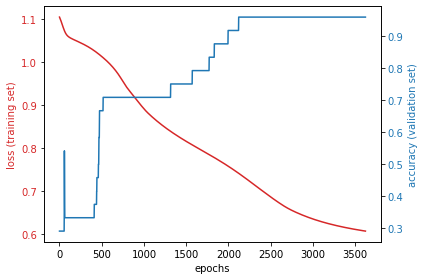

In [5]:
train = 1
# check for a saved model file from a previous training run
if path.exists(model_path):
    # if a model has been saved, decide whether to load it or not
    answer = input('Load the pretrained model? [0=no, everything else=yes] ')
    if answer!='0':
        train = 0
# if there is a pretrained model AND it shall be loaded, then do load it ...
if train==0:
    model.load_state_dict(torch.load(model_path))
    print('The pretrained model has been loaded.')
# ... otherwise, train the model from scratch (and save the trained model)
else:
    print('Training the model ...')
    # loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    # train the model
    epochs = 5000
    losses = []
    valid_accs = []
    max_valid_acc = 0
    stagnation_count = 0
    stagnation_threshold = 1500
    for epoch in range(epochs):
        # predictions, loss, gradient, gradient step
        Y_pred = model(X)
        loss = loss_fn(Y_pred, Y.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # accuracy on validation set
        Y_valid_logits = model(X_valid)
        _, Y_valid_pred = torch.max(Y_valid_logits, 1)
        valid_acc = accuracy_score(Y_valid_pred, Y_valid)
        # log loss and accuracy
        losses.append(loss.item())
        valid_accs.append(valid_acc)
        # print output
        print('Epoch: {:d}\tLoss: {:.4f}\tAccuracy on validation set: {:.4f}'.format(epoch, loss.item(), valid_acc))
        # early stopping
        if valid_acc > max_valid_acc:
            #torch.save(model, model_path)
            torch.save(model.state_dict(), model_path)
            max_valid_acc = valid_acc
            stagnation_count = 0
            print('Accuracy on validation set has just improved!')
            print ('The model has been saved under ' + model_path + '.')
        else:
            stagnation_count += 1
            if stagnation_count > stagnation_threshold:
                print('Early stopping!')
                break
    # make a nice plot showing the loss (on training set) and the accuary (on validation set) over epochs
    fig, ax1 = plt.subplots()
    color1 = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss (training set)', color=color1)
    ax1.plot(losses, color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel('accuracy (validation set)', color=color2)
    ax2.plot(valid_accs, color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    fig.tight_layout()
    plt.show()

Finally, use the model (whether newly trained from scratch or trained previously and imported) to make predictions on the unseen test set.

In [6]:
# predict output of test data
Y_predict = model(X_test)
_, labels = torch.max(Y_predict, 1)
accuracy_score(labels, Y_test)

0.9666666666666667

*Tip:* Seldomly, the model does not perform well. Run the training cell again, choosing not to load the saved model. This will give you extra training epochs on the already trained model and the loss should continue to decrease. If necessary, do this over and over again until the model performs well. Otherwise, you can also start from scratch and hope for better initialization of the weights and biases.